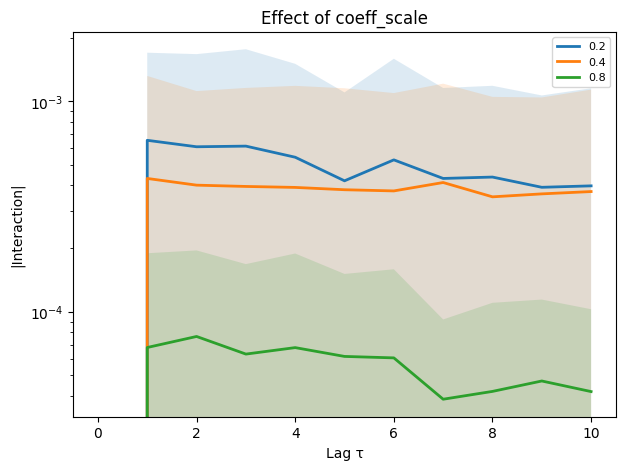

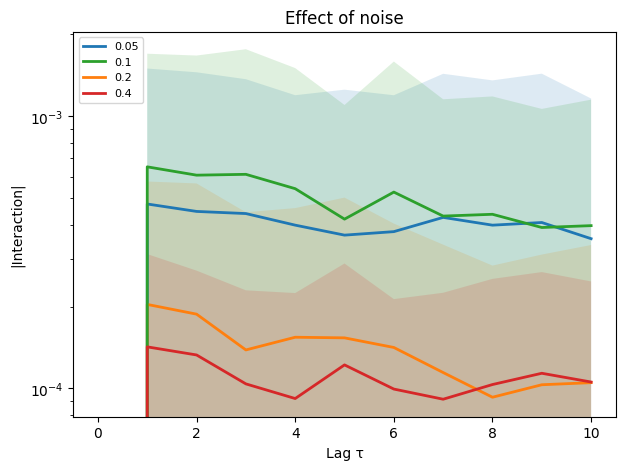

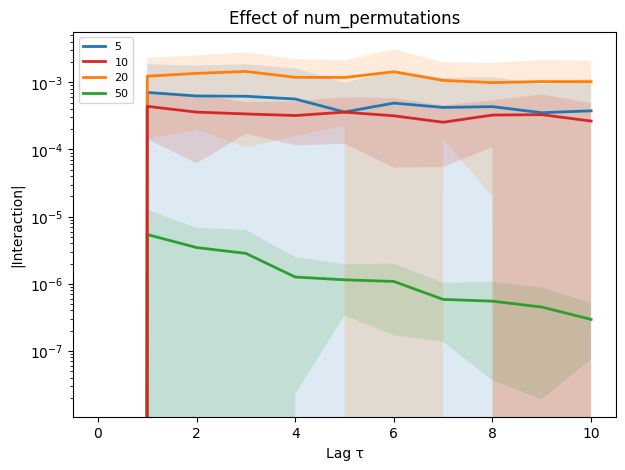

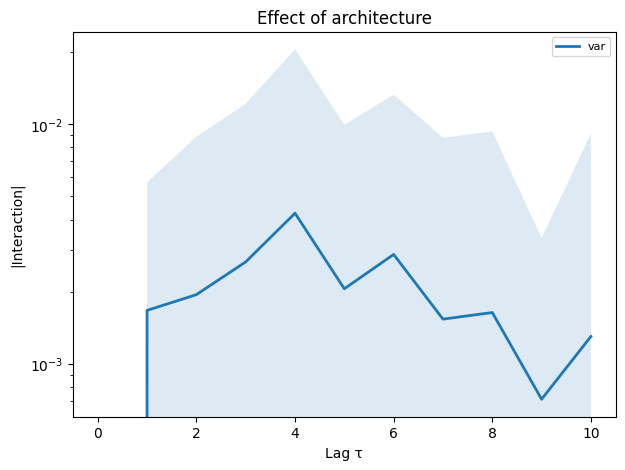

In [ ]:
import os, re, pickle
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

def aggregate_lag_curve(lag_dict, tau_max, reduce="median"):
    """
    Aggregate lag_dict into lag curves.
    Args:
      lag_dict: {(tau, d, d'): np.ndarray[N]}
      tau_max: maximum tau
      reduce: 'median' | 'mean' (how to reduce across pairs)
    Returns:
      curve: np.ndarray[tau_max+1, N]  # per-sample lag curve
    """
    # Find N from one entry
    first_val = next(iter(lag_dict.values()))
    N = first_val.shape[0]

    curve = np.zeros((tau_max + 1, N))
    for tau in range(tau_max + 1):
        vals = [np.abs(v) for (tau_, d, d2), v in lag_dict.items() if tau_ == tau]  # list of [N]
        if vals:
            vals = np.stack(vals, axis=0)  # [num_pairs, N]
            if reduce == "median":
                curve[tau] = np.median(vals, axis=0)  # [N]
            else:
                curve[tau] = np.mean(vals, axis=0)    # [N]
        else:
            curve[tau] = 0.0
    return curve  # [tau_max+1, N]

BASE_DIR = Path("../runs/var")
TAU_MAX = 10  # adjust if needed

# --------------------------------
# Helpers
# --------------------------------
import re

def parse_run_name(run_dir):
    """
    Parse run folder name into a dict of hyperparams.
    Example: tau_max10_num_permutations5_coeff_scale0.2_noise0.1_explainertimex
    """
    name = run_dir.name
    params = {}

    # regex patterns for each param
    patterns = {
        "tau_max": r"tau_max(\d+)",
        "num_permutations": r"num_permutations(\d+)",
        "coeff_scale": r"coeff_scale([0-9.]+)",
        "noise": r"noise([0-9.]+)",
        "explainer": r"explainer(\w+)"
    }

    for key, pat in patterns.items():
        m = re.search(pat, name)
        if m:
            if key in ["tau_max", "num_permutations"]:
                params[key] = int(m.group(1))
            elif key in ["coeff_scale", "noise"]:
                params[key] = float(m.group(1))
            else:
                params[key] = m.group(1)

    return params


def load_curve(run_dir, tau_max=TAU_MAX, use="mean"):
    """Load aggregated curve from lag_dict_(mean|median).pkl"""
    fname = "lag_dict_mean.pkl" if use == "mean" else "lag_dict_median.pkl"
    fpath = run_dir / fname
    if not fpath.exists():
        print(f"❌ Missing {fname} in {run_dir}")
        return None

    with open(fpath, "rb") as f:
        lag_dict = pickle.load(f)

    curve = aggregate_lag_curve(lag_dict, tau_max=tau_max)
    # print(f"✅ Loaded {fname} from {run_dir}")
    return curve


def plot_grouped_curves(group_runs, tau_max=TAU_MAX, use="mean", title=None, sort_labels=True, log_y=True):
    """
    group_runs: dict[label -> list of run_dirs]
    """
    plt.figure(figsize=(7, 5))
    for label, runs in group_runs.items():
        curves = []
        for run_dir in runs:
            curve = load_curve(run_dir, tau_max, use)
            if curve is not None:
                curves.append(curve)

        if not curves:
            continue
        curves = np.array(curves)

        # Handle 1D or 2D curves
        if curves.ndim == 3:   # multiple [tau,N] curves stacked
            agg = curves.mean(axis=(0,2))
            std = curves.std(axis=(0,2))
        elif curves.ndim == 2: # multiple [tau] curves stacked
            agg = curves.mean(axis=0)
            std = curves.std(axis=0)
        else: # single curve
            agg = curves
            std = np.zeros_like(agg)

        plt.plot(range(len(agg)), agg, lw=2, label=str(label))
        plt.fill_between(range(len(agg)), agg-std, agg+std, alpha=0.15)

    plt.xlabel("Lag τ")
    plt.ylabel("|Interaction|")
    if log_y:
        plt.yscale("log")
    plt.title(title or f"Overlay ({use})")

    # --- sort legend labels ---
    handles, labels = plt.gca().get_legend_handles_labels()
    if sort_labels:
        try:
            labels_numeric = [float(l) for l in labels]
            order = np.argsort(labels_numeric)
        except ValueError:
            order = np.argsort(labels)
        handles = [handles[i] for i in order]
        labels = [labels[i] for i in order]
    plt.legend(handles, labels, fontsize=8)

    plt.show()



# --------------------------------
# Collect all runs
# --------------------------------
all_runs = [p for p in BASE_DIR.rglob("*") if p.is_dir() and (p/"lag_dict_mean.pkl").exists()]
meta = [(r, parse_run_name(r)) for r in all_runs]
# print(meta[0])

# --------------------------------
# Example overlays
# --------------------------------

# Compare different coeff_scale (fix noise & arch)
def group_by_coeff_scale(arch="lstm", noise=0.1):
    group = {}
    for r, params in meta:
        if params.get("noise")==noise and arch in str(r):
            group[params["coeff_scale"]] = group.get(params["coeff_scale"], []) + [r]
    return group


# Compare different noise levels (fix coeff_scale & arch)
def group_by_noise(arch="lstm", coeff_scale=0.2):
    group = {}
    for r, params in meta:
        if params.get("coeff_scale")==coeff_scale and arch in str(r):
            group[params["noise"]] = group.get(params["noise"], []) + [r]
    return group


# Compare different num_permutations (fix coeff_scale, noise & arch)
def group_by_permutations(arch="lstm", coeff_scale=0.2, noise=0.1):
    group = {}
    for r, params in meta:
        if params.get("coeff_scale")==coeff_scale and params.get("noise")==noise and arch in str(r):
            group[params["num_permutations"]] = group.get(params["num_permutations"], []) + [r]
    return group


# Compare architectures (fix coeff_scale, noise, permutations)
def group_by_arch(coeff_scale=0.2, noise=0.1, num_permutations=5):
    group = {}
    for r, params in meta:
        if (params.get("coeff_scale")==coeff_scale and 
            params.get("noise")==noise and 
            params.get("num_permutations")==num_permutations):
            arch = r.parts[2]  # "lstm", "tcn", etc.
            group[arch] = group.get(arch, []) + [r]
    return group


plot_grouped_curves(group_by_coeff_scale("lstm", noise=0.1),
                    tau_max=TAU_MAX, use="mean", title="Effect of coeff_scale")

plot_grouped_curves(group_by_noise("lstm", coeff_scale=0.2),
                    tau_max=TAU_MAX, use="mean", title="Effect of noise")

plot_grouped_curves(group_by_permutations("lstm", coeff_scale=0.2, noise=0.1),
                    tau_max=TAU_MAX, use="mean", title="Effect of num_permutations")

plot_grouped_curves(group_by_arch(coeff_scale=0.2, noise=0.1, num_permutations=5),
                    tau_max=TAU_MAX, use="mean", title="Effect of architecture")